In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from tensorflow.keras.utils import plot_model

In [2]:
dataset = tf.keras.datasets.mnist.load_data()

(train_images, train_label), (test_images, test_label) = dataset

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    '''
    Description: This function creates a generator model for a Generative Adversarial Network (GAN).
    The generator model generates new, synthetic data that resembles some known data distribution.

    Input:
    This function does not take any input.

    Output:
    The function returns a Sequential model that consists of several layers of neural networks.

    The model takes a 100-dimensional noise vector as input and outputs a 28x28 grayscale image.
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


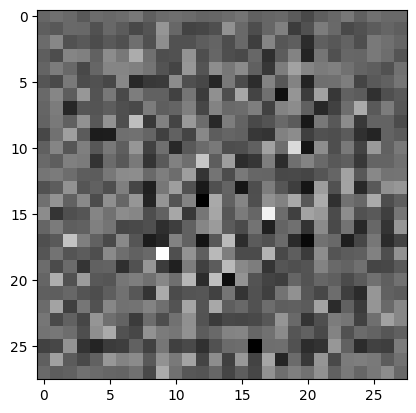

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [45]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

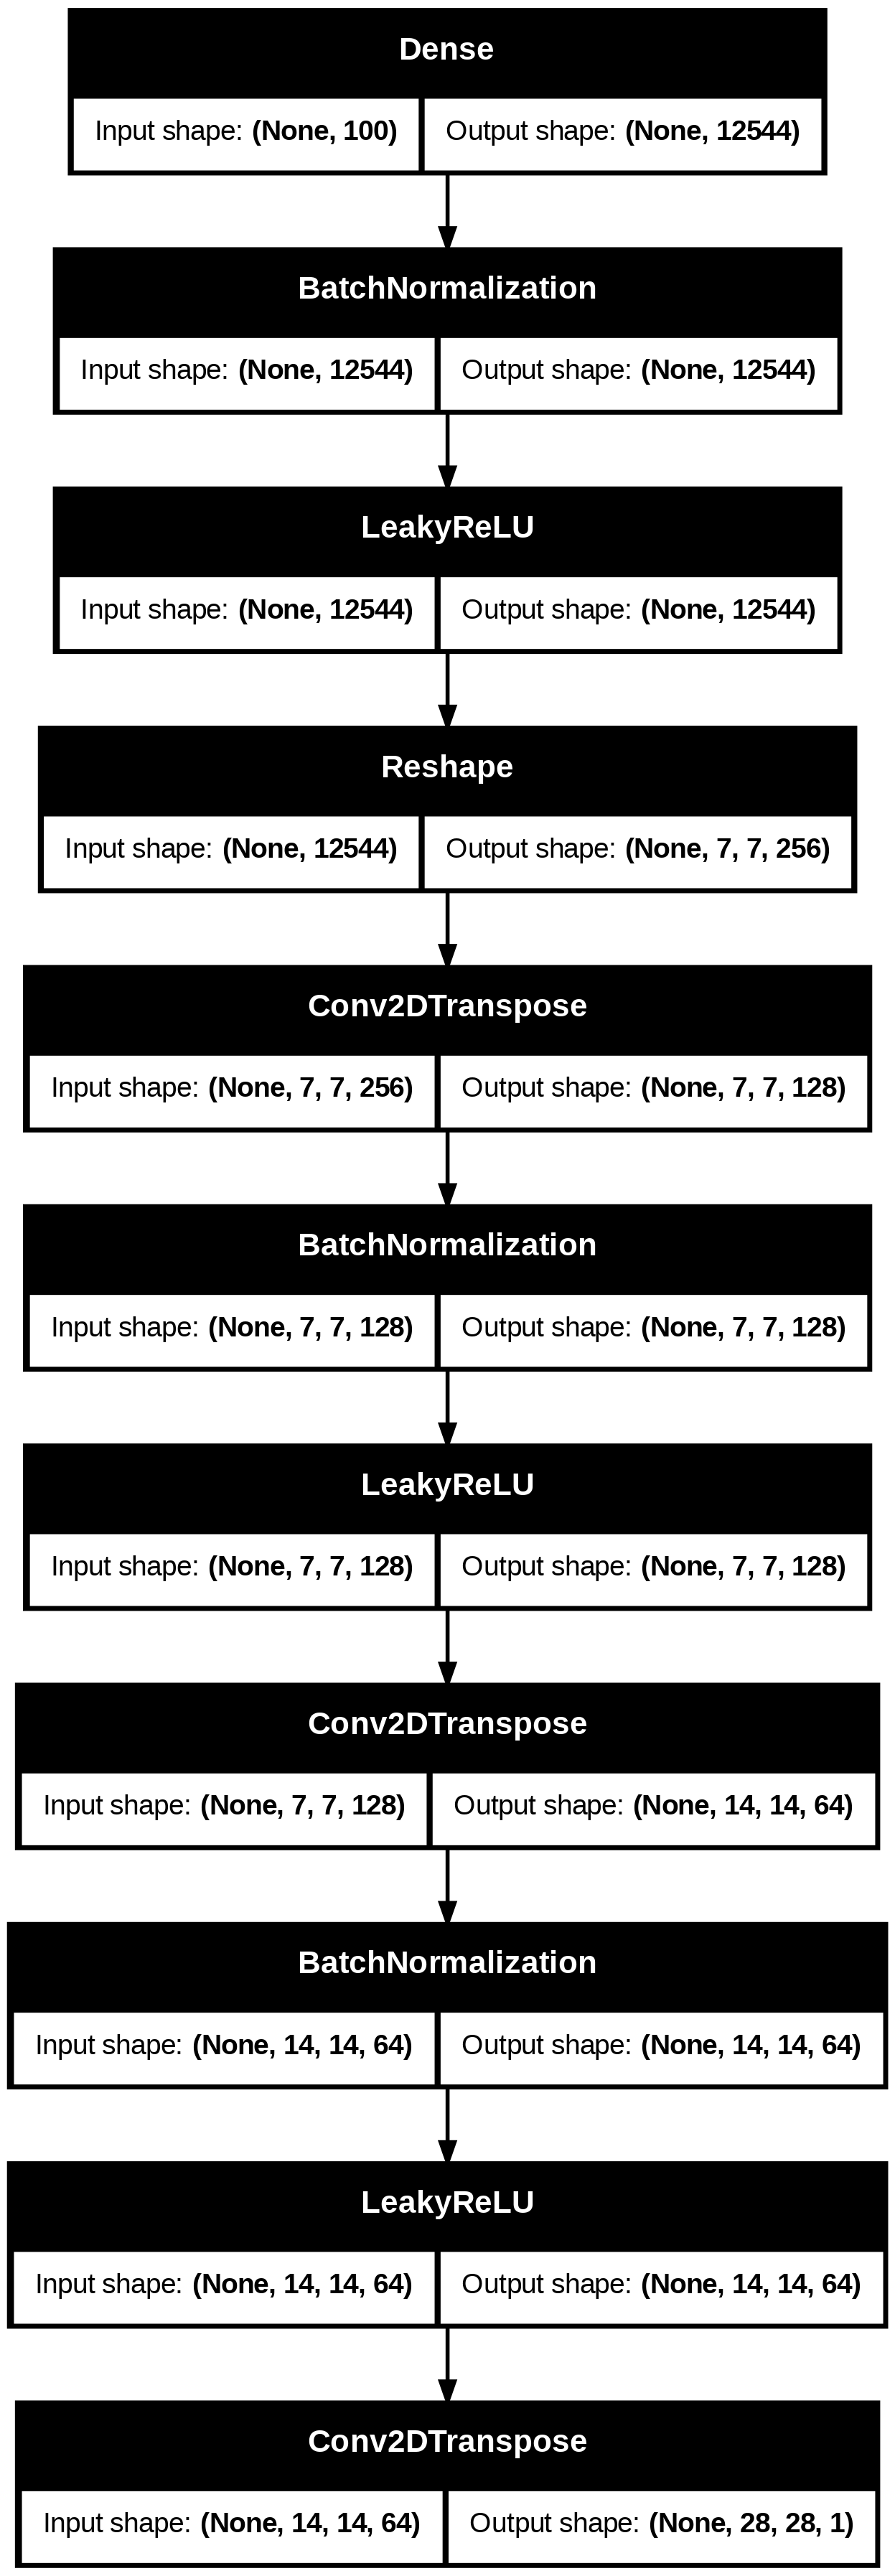

In [44]:
plot_model(generator, show_shapes=True)

In [8]:
def make_discriminator_model():
    """
    Returns a discriminator model using Convolutional Neural Network (CNN) architecture.

    Input:
    This function does not take any input.

    Returns:
    model : A tf.keras.Sequential model representing the discriminator

    Input shape of model: (batch_size, 28, 28, 1)
    Output shape of model: (batch_size, 1)
    """
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
def get_decision(decision):
  """
  This function takes in a decision tensor generated by the discriminator and
  prints whether the image is real or generated by the AI. If the decision value
  is less than 0, the image is considered to be generated by the AI, and
  if it is greater than or equal to 0, the image is considered to be real.

  Input:
  decision: Tensor of shape (1, 1) containing the decision value for an image generated by the discriminator

  Returns:
  None
  """

  val = decision.numpy()[0, 0]
  if val < 0:
    print("AI generated image")
  else:
    print("real image")

In [24]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
get_decision(decision)

AI generated image


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    """
    Computes the discriminator loss.

    Args:
    - real_output: A tensor representing the output of the discriminator on real images.
    - fake_output: A tensor representing the output of the discriminator on fake images.

    Returns:
    - total_loss: A scalar tensor representing the total discriminator loss.
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """
    Computes the generator loss.

    Args:
    - fake_output: A tensor representing the output of the discriminator on fake images.

    Returns:
    - A scalar tensor representing the generator loss.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    """
    Performs a single training step on the GAN model.

    Args:
        images: A batch of real images.

    Returns:
        None - Applying gradient to the trainable variables of the
        generator and discriminator models using the Adam optimizer
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def generate_images(model, epoch, test_input):
    """
    Generate and save images using the generator model.

    Args:
        - model: generator model
        - epoch (int): current epoch number
        - test_input: input noise for the generator model

    Returns:
        None

    Notice `training` is set to False.
    This is so all layers run in inference mode (batchnorm).
    """
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [19]:
def prediction(dataset, epochs):
  """
  Description:

  This function takes a dataset of images and an integer epochs as inputs.
  It trains the generator and discriminator models for the specified number of
  epochs using the train_step function. It generates images using the
  generate_images function for every epoch.

  Args:
      - dataset: A TensorFlow dataset of images.
      - epochs: An integer specifying the number of epochs to train the models.

  Returns:
      None
  """
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,
                           epochs,
                           seed)

In [20]:
def train(dataset, epochs):
  """
  Trains the Generative Adversarial Network (GAN) model for the specified number of epochs.

  Args:
      - dataset: The input dataset used for training.
      - epochs (int): The number of epochs to train the model.

  Returns:
      None
  """
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,
                           epochs,
                           seed)

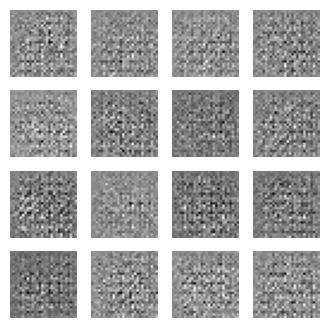

In [27]:
train(train_dataset, EPOCHS)

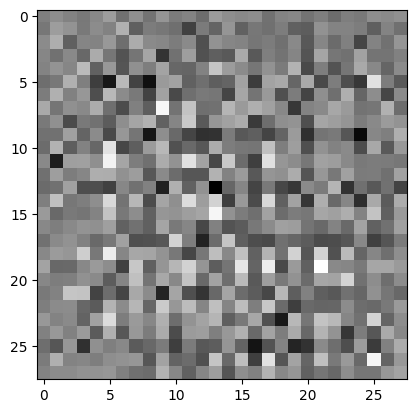

In [28]:
noise = tf.random.normal([1, 100])
generated_image_2 = generator(noise, training=False)

plt.imshow(generated_image_2[0, :, :, 0] * 127.5 + 127.5, cmap='gray')

In [29]:
decision_2 = discriminator(generated_image_2)
get_decision(decision_2)

real image


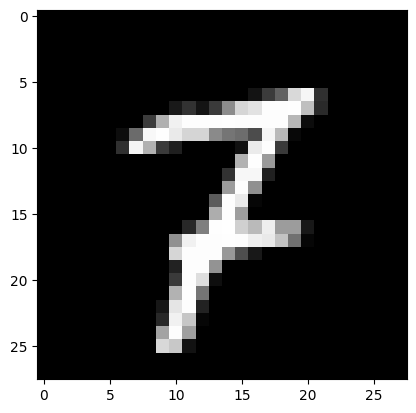

real image


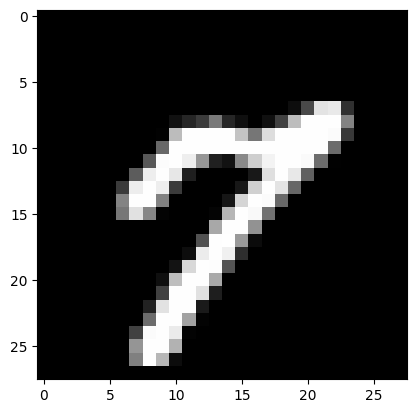

real image


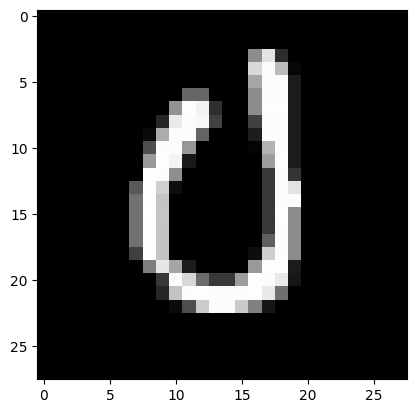

real image


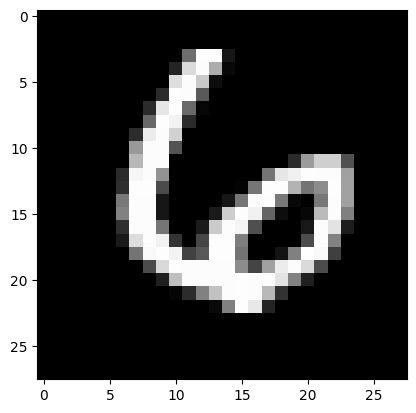

real image


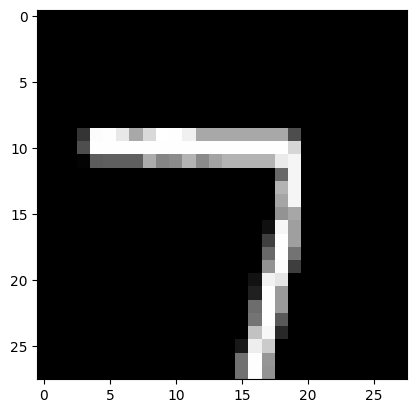

real image


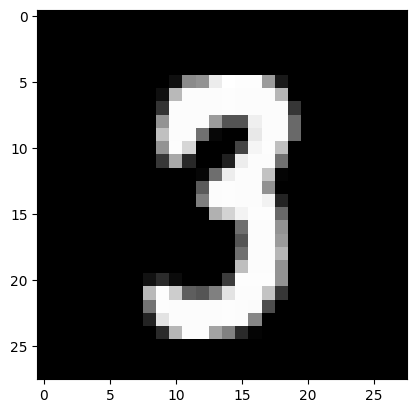

real image


In [30]:
count = 0
for image in test_dataset:
  # show images
  plt.imshow(image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.show()

  # predict
  decision = discriminator(tf.expand_dims(image[0 , :, :, :], axis=0))
  get_decision(decision)

  count += 1
  if count > 5:
    break

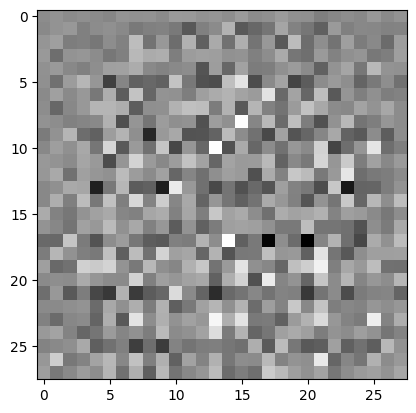

real image


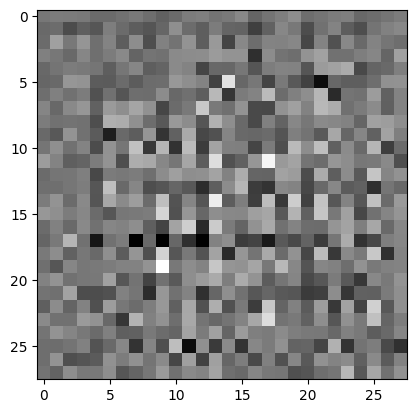

real image


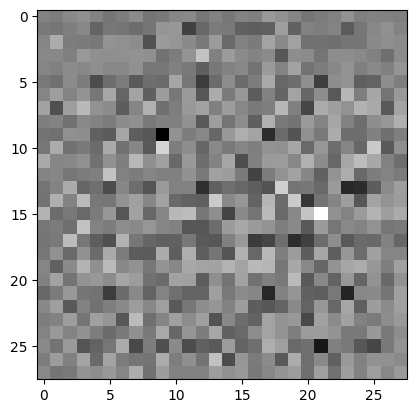

real image


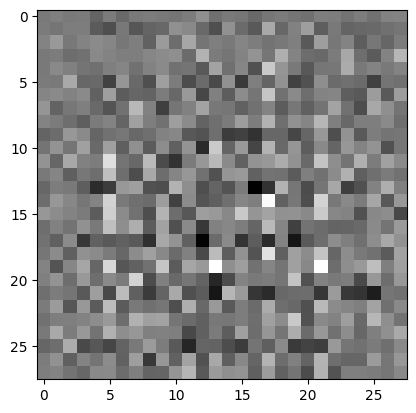

real image


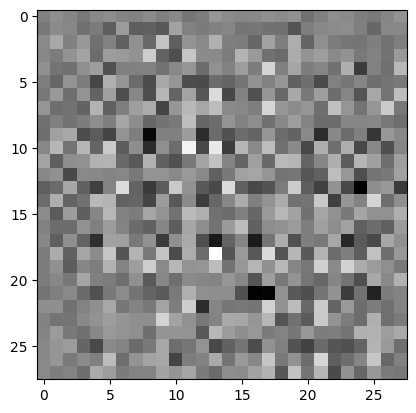

AI generated image


In [31]:
for i in range(0, 5):
  # show images
  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)

  plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.show()
  # predict
  decision = discriminator(generated_image)
  get_decision(decision)

In [32]:
result = {'correct' : 0,
          'incorrect' : 0}

for image in test_dataset:
  # predict
  decision = discriminator(tf.expand_dims(image[0 , :, :, :], axis=0))
  get_decision(decision)
  if decision.numpy()[0, 0] > 0:
    result['correct'] += 1
  else:
    result['incorrect'] += 1

real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image


In [33]:
percentage_correct_real = round(100*result['correct']/len(test_dataset))

print('Discriminator can detect {}% of real image correctly as real image!'.format(percentage_correct_real))

Discriminator can detect 100% of real image correctly as real image!


In [34]:
result_generator = {'correct' : 0,
                    'incorrect' : 0}
for i in range(0, len(test_dataset)):
  # show images
  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)

  # predict
  decision = discriminator(generated_image)
  get_decision(decision)
  if decision.numpy()[0, 0] < 0:
    result_generator['correct'] += 1
  else:
    result_generator['incorrect'] += 1

real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
AI generated image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
real image
AI generated image


In [35]:
percentage_correct_fake = round(100*result_generator['correct']/len(test_dataset))
percentage_generator_tricked = round(100*result_generator['incorrect']/len(test_dataset))

print('Discriminator can detect {}% of generated image correctly as fake image!'.format(percentage_correct_fake))
print('Generator can trick discirmator in {}% of generated iamges!'.format(percentage_generator_tricked))

Discriminator can detect 5% of generated image correctly as fake image!
Generator can trick discirmator in 95% of generated iamges!


In [36]:
def get_accuracy():

    result = {'correct' : 0,
          'incorrect' : 0}

    for image in test_dataset:
      # predict
      decision = discriminator(tf.expand_dims(image[0 , :, :, :], axis=0))
      if decision.numpy()[0, 0] > 0:
        result['correct'] += 1
      else:
        result['incorrect'] += 1

    percentage_correct_real = round(100*result['correct']/len(test_dataset))


    result_generator = {'correct' : 0,
                    'incorrect' : 0}
    for i in range(0, len(test_dataset)):
      # show images
      noise = tf.random.normal([1, 100])
      generated_image = generator(noise, training=False)

      # predict
      decision = discriminator(generated_image)
      if decision.numpy()[0, 0] < 0:
        result_generator['correct'] += 1
      else:
        result_generator['incorrect'] += 1

    percentage_correct_fake = round(100*result_generator['correct']/len(test_dataset))
    percentage_generator_tricked = round(100*result_generator['incorrect']/len(test_dataset))

    return percentage_correct_real, percentage_correct_fake, percentage_generator_tricked

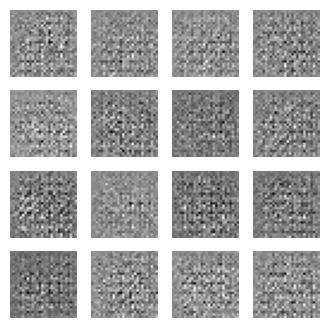

In [37]:
train(train_dataset, 50)

In [38]:
percentage_correct_real, percentage_correct_fake, percentage_generator_tricked = get_accuracy()
print('Discriminator can detect {}% of real image correctly as real image!'.format(percentage_correct_real))
print('Discriminator can detect {}% of generated image correctly as fake image!'.format(percentage_correct_fake))
print('Generator can trick discirmator in {}% of generated iamges!'.format(percentage_generator_tricked))

Discriminator can detect 100% of real image correctly as real image!
Discriminator can detect 8% of generated image correctly as fake image!
Generator can trick discirmator in 92% of generated iamges!


real image


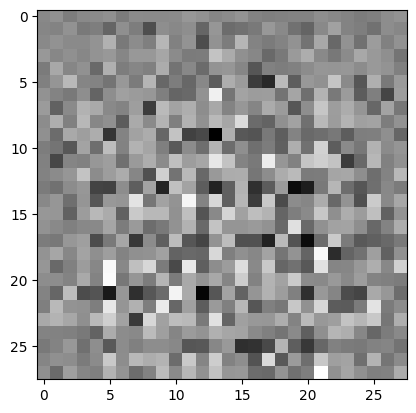

In [39]:
noise = tf.random.normal([1, 100])
generated_image_2 = generator(noise, training=False)

plt.imshow(generated_image_2[0, :, :, 0] * 127.5 + 127.5, cmap='gray')

decision_2 = discriminator(generated_image_2)
get_decision(decision_2)

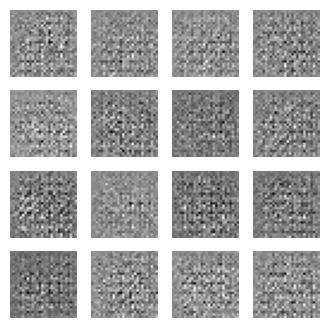

In [41]:
train(train_dataset, 100)

In [42]:
percentage_correct_real, percentage_correct_fake, percentage_generator_tricked = get_accuracy()
print('Discriminator can detect {}% of real image correctly as real image!'.format(percentage_correct_real))
print('Discriminator can detect {}% of generated image correctly as fake image!'.format(percentage_correct_fake))
print('Generator can trick discirmator in {}% of generated iamges!'.format(percentage_generator_tricked))

Discriminator can detect 100% of real image correctly as real image!
Discriminator can detect 8% of generated image correctly as fake image!
Generator can trick discirmator in 92% of generated iamges!


real image


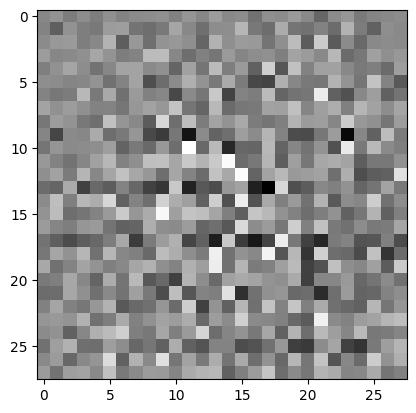

In [43]:
noise = tf.random.normal([1, 100])
generated_image_2 = generator(noise, training=False)

plt.imshow(generated_image_2[0, :, :, 0] * 127.5 + 127.5, cmap='gray')

decision_2 = discriminator(generated_image_2)
get_decision(decision_2)